# Task1: Play with NetVLAD

## Work done last week (Evil version i.e., bad version)
which we will show later it is indeed bad.

work adapted from https://github.com/lyakaap/NetVLAD-pytorch

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from PIL import Image
from netvlad_evil import NetVLAD
from netvlad_evil import EmbedNet
from hard_triplet_loss import HardTripletLoss
from torchvision.models import resnet18


def VLAD_for_single_image_evil(img):
    # Discard layers at the end of base network
    encoder = resnet18(pretrained=True)
    base_model = nn.Sequential(
        encoder.conv1,
        encoder.bn1,
        encoder.relu,
        encoder.maxpool,
        encoder.layer1,
        encoder.layer2,
        encoder.layer3,
        encoder.layer4
    )
    dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

    # Define model for embedding
    net_vlad = NetVLAD(num_clusters=64, dim=dim, alpha=1.0)
    model = EmbedNet(base_model, net_vlad)

    # Define loss
    criterion = HardTripletLoss(margin=0.1)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])
    x = preprocess(img)
    x = x.unsqueeze(0)
    
    output = model(x)

    print('VLAD encoding: {}'.format(output))
    print('VLAD encoding shape: {}'.format(output.shape))

    return output

ModuleNotFoundError: No module named 'netvlad_evil'

## Work done this week (Works great! Yay!)
adapted from https://github.com/Nanne/pytorch-NetVlad

### Adapt main.py
Define a function VLAD_for_single_image for our use.

In [2]:
from __future__ import print_function
import random
from os.path import join, isfile

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import numpy as np
import netvlad
import os
from sklearn.decomposition import PCA
import pickle as pk
 
def VLAD_for_single_image(img):
    cuda = False
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run with --nocuda")

    device = torch.device("cuda" if cuda else "cpu")

    default_seed = 123
    random.seed(default_seed)
    np.random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed(default_seed)

    print('===> Loading data')
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
    ])
    input = preprocess(img)
    input = input.unsqueeze(0)
    print('Input image shape: {}'.format(input.shape))

    print('===> Building model')

    pretrained = True

    encoder_dim = 512
    encoder = models.vgg16(pretrained=pretrained)
    # capture only feature part and remove last relu and maxpool
    layers = list(encoder.features.children())[:-2]

    if pretrained:
        # if using pretrained then only train conv5_1, conv5_2, and conv5_3
        for l in layers[:-5]: 
            for p in l.parameters():
                p.requires_grad = False


    encoder = nn.Sequential(*layers)
    model = nn.Module() 
    model.add_module('encoder', encoder)

    default_num_clusters = 64
    defauly_vladv2 = False
    print('NetVLAD setting:\nnum_clusters: {} dim: {} vladv2: {}'.format(default_num_clusters, encoder_dim, defauly_vladv2))
    net_vlad = netvlad.NetVLAD(num_clusters=default_num_clusters, dim=encoder_dim, vladv2=defauly_vladv2)
    model.add_module('pool', net_vlad)

    checkpoint_path = 'vgg16_netvlad_checkpoint'
    resume_ckpt = join(checkpoint_path, 'checkpoints', 'checkpoint.pth.tar')

    if isfile(resume_ckpt):
        print("=> loading checkpoint '{}'".format(resume_ckpt))
        checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
        start_epoch = checkpoint['epoch']
        best_metric = checkpoint['best_score']
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(device)
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume_ckpt, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume_ckpt))

    print('===> Running evaluation step')
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 
    print('VLAD encoding: {}'.format(vlad_encoding))
    print('VLAD encoding shape: {}'.format(vlad_encoding.shape))
    return vlad_encoding

### Functionality Test 
Note: _evil indicates the NetVLAD model from last week, which is consider to be written in evil coding style

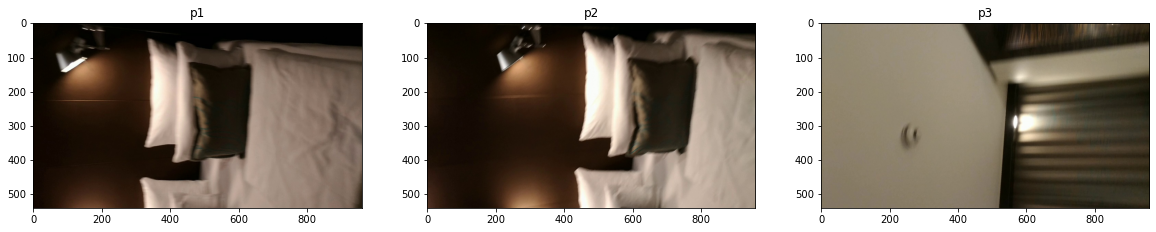

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
p1 = Image.open('./000/3RScan/q1.jpg')
p2 = Image.open('./000/3RScan/q2.jpg')
p3 = Image.open('./000/3RScan/q3.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)
plt.subplot(1, 3, 2)
plt.title('p2')
plt.imshow(p2)
plt.subplot(1, 3, 3)
plt.title('p3')
plt.imshow(p3)

In [4]:
p1_vlad = VLAD_for_single_image(p1)
p2_vlad = VLAD_for_single_image(p2)
p3_vlad = VLAD_for_single_image(p3)

dummy_p = np.zeros(p1_vlad.shape)
p_vlad_concat_matr = np.concatenate((dummy_p, p1_vlad), axis=0)
print((p1_vlad))
print((p2_vlad))
print((p3_vlad))

===> Loading data
Input image shape: torch.Size([1, 3, 540, 960])
===> Building model


/home/igor/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/igor/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026, -0.0072,  0.0050,  ...,  0.0034,  0.0063,  0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 540, 960])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0006, -0.0076,  0.0020,  ...,  0.0002,  0.0062,  0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 540, 960])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

In [5]:
import os 
count = 0 
directory = './images_for_pca_3000/'
for image in os.listdir(directory):
    f = os.path.join(directory, image)
    if os.path.isfile(f):
        count = count + 1
print(count)

3003


In [6]:
import os 
count = 0 
directory = './images_for_pca_3000/'
for image in os.listdir(directory):
    f = os.path.join(directory, image)
    if os.path.isfile(f):
        p = Image.open(f)
        p_vlad = VLAD_for_single_image(p)
        p_vlad_concat_matr = np.concatenate((p_vlad_concat_matr, p_vlad), axis=0)
p_vlad_concat_matr = p_vlad_concat_matr[2:]

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0091, -0.0048,  0.0084,  ...,  0.0097,  0.0028, -0.0046]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0046,  0.0167, -0.0038,  ...,  0.0133,  0.0057, -0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 4

VLAD encoding: tensor([[-0.0016,  0.0006, -0.0073,  ...,  0.0005,  0.0042, -0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014, -0.0085, -0.0100,  ...,  0.0163,  0.0059,  0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0062,  0.0014, -0.0032,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0063, -0.0035,  0.0031,  ...,  0.0032,  0.0003, -0.0038]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0098, -0.0093,  0.0005,  ...,  0.0071,  0.0019, -0.0016]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0006, -0.0077, -0.0043,  ...,  0.0022,  0.0076, -0.0013]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0019,  0.0035, -0.0057,  ..., -0.0032,  0.0003, -0.0001]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0003, -0.0093,  0.0007,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0013, -0.0156,  0.0033,  ...,  0.0009,  0.0076, -0.0010]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0030,  0.0021, -0.0034,  ...,  0.0126,  0.0071, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0073, -0.0046, -0.0009,  ...,  0.0057,  0.0055,  0.0024]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0002, -0.0014,  0.0121,  ...,  0.0028,  0.0036,  0.0006]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0042, -0.0062,  0.0057,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0059, -0.0039, -0.0024,  ...,  0.0130,  0.0025, -0.0045]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0044, -0.0018,  0.0019,  ..., -0.0107, -0.0026,  0.0113]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0038,  0.0185, -0.0040,  ...,  0.0171,  0.0098, -0.0002]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0043,  0.0108,  0.0002,  ...,  0.0070,  0.0106, -0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0019, -0.0121,  0.0079,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-4.9442e-03,  6.0083e-03,  7.3152e-05,  ...,  1.4737e-02,
          4.8716e-03, -4.3911e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0020,  0.0017,  0.0046,  ...,  0.0009,  0.0051,  0.0060]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-7.5037e-03, -9.2959e-03, -4.5878e-04,  ...,  1.0126e-02,
          2.4132e-05, -1.9075e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 8.9255e-04,  5.9142e-03, -5.0199e-05,  ...,  2.8755e-03,
         -3.0203e-04,  2.2615e-04]])
VLAD encoding shape: torch.Size([1

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0072, -0.0022,  0.0076,  ...,  0.0172,  0.0025,  0.0085]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0066, -0.0088, -0.0070,  ...,  0.0197,  0.0054,  0.0015]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-2.3176e-03, -2.3235e-03,  7.1463e-03,  ..., -2.6585e-05,
          3.5828e-05,  4.6689e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0031, -0.0015,  0.0048,  ...,  0.0058,  0.0049,  0.0051]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0022,  0.0101, -0.0075,  ...,  0.0007,  0.0045,  0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0025, -0.0088, -0.0032,  ...,  0.0022,  0.0017,  0.0042]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0117,  0.0070, -0.0011,  ...,  0.0065,  0.0030, -0.0061]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-7.4492e-03,  4.4958e-03, -1.7157e-03,  ...,  1.5021e-02,
         -1.6898e-05, -3.4548e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026, -0.0129,  0.0060,  ...,  0.0210,  0.0070, -0.0021]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0007,  0.0067, -0.0013,  ..., -0.0116,  0.0028,  0.0044]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0026, -0.0040,  0.0013,  ...,  0.0020,  0.0024,  0.0043]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0011, -0.0116, -0.0051,  ..., -0.0003, -0.0013, -0.0006]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0066, -0.0024,  0.0012,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0031, -0.0004,  0.0009,  ..., -0.0006,  0.0026,  0.0101]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0017,  0.0121,  0.0004,  ...,  0.0193,  0.0027, -0.0053]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0038, -0.0101, -0.0087,  ...,  0.0134,  0.0054, -0.0096]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0021,  0.0035, -0.0047,  ...,  0.0021,  0.0003,  0.0013]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0002,  0.0032, -0.0004,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0051,  0.0041, -0.0004,  ...,  0.0108,  0.0077,  0.0002]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 4.9498e-04, -6.3025e-03, -8.6951e-04,  ...,  1.4868e-03,
         -3.8513e-03, -8.6748e-05]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[-0.0054, -0.0104, -0.0052,  ...,  0.0059,  0.0030,  0.0046]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0026, -0.0112,  0.0022,  ...,  0.0033,  0.0030, -0.0080]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 9.4507e-05, -1.4915e-02,  1.647

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0058,  0.0017, -0.0008,  ..., -0.0016,  0.0058, -0.0028]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0069, -0.0015,  0.0071,  ..., -0.0020, -0.0042,  0.0100]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0020,  0.0185, -0.0001,  ...,  0.0112,  0.0071, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0117, -0.0090,  0.0107,  ...,  0.0093, -0.0007, -0.0014]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-7.2551e-04,  3.6897e-03, -2.867

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0026, -0.0104,  0.0012,  ...,  0.0153,  0.0054,  0.0009]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0033, -0.0102,  0.0087,  ...,  0.0003,  0.0067,  0.0114]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0039,  0.0139, -0.0004,  ...,  0.0099,  0.0052, -0.0043]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0062, -0.0057, -0.0005,  ..., -0.0014,  0.0127,  0.0083]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014,  0.0031, -0.0028,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0081,  0.0050, -0.0014,  ..., -0.0067,  0.0046,  0.0091]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[0.0068, 0.0078, 0.0010,  ..., 0.0011, 0.0174, 0.0053]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> lo

VLAD encoding: tensor([[ 0.0026, -0.0036,  0.0014,  ...,  0.0098, -0.0013, -0.0047]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0056, -0.0072,  0.0080,  ...,  0.0211,  0.0019, -0.0012]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0059, -0.0032, -0.0030,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0050,  0.0138,  0.0020,  ...,  0.0042,  0.0039, -0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-1.0790e-03,  2.6043e-05,  4.5016e-03,  ...,  1.4450e-02,
         -2.1455e-04, -1.1704e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0009, -0.0068,  0.0058,  ...,  0.0009, -0.0060, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0039, -0.0092,  0.0049,  ...,  0.0048,  0.0040,  0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0013, -0.0063,  0.0044,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0074,  0.0101,  0.0026,  ..., -0.0034, -0.0047,  0.0041]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0018, -0.0036,  0.0072,  ...,  0.0061,  0.0092, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0015,  0.0093, -0.0056,  ..., -0.0009,  0.0025,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-3.0127e-03, -4.2502e-03, -2.5681e-05,  ...,  9.9105e-03,
          3.2972e-03, -4.1624e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-4.0114e-05, -7.4239e-03,  1.3027e-02,  ...,  3.9588e-04,
          3.5764e-03,  3.6480e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0015, -0.0012,  0.0005,  ..., -0.0043,  0.0093, -0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0055, -0.0006, -0.0044,  ...,  0.0104,  0.0018,  0.0056]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-5.6338e-05,  1.1475e-02, -3.4228e-04,  ...,  1.0476e-02,
          5.3654e-03, -8.0567e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0095, -0.0060, -0.0054,  ...,  0.0017,  0.0001,  0.0009]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0026, -0.0033,  0.0031,  ..., -0.0100,  0.0010,  0.0069]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0016, -0.0079,  0.0055,  ...,  0.0025,  0.0048,  0.0035]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0066, -0.0014,  0.0011,  ...,  0.0075,  0.0069,  0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0051,  0.0090,  0.0018,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0017, -0.0060, -0.0061,  ...,  0.0019,  0.0038, -0.0036]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0051, -0.0123,  0.0026,  ...,  0.0205,  0.0063, -0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[0.0054, 0.0005, 0.0079,  ..., 0.0005, 0.0028, 0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0028,  0.0012,  0.0033,  ..., -0.0030,  0.0075,  0.0021]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0022, -0.0081,  0.0016,  ..., -0.00

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0033,  0.0065, -0.0059,  ..., -0.0016,  0.0054,  0.0068]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0058,  0.0014, -0.0004,  ...,  0.0094,  0.0043,  0.0052]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0003,  0.0254, -0.0036,  ...,  0.0127,  0.0077, -0.0026]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0009, -0.0011, -0.0009,  ...,  0.0095, -0.0006,  0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0080, -0.0052, -0.0021,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0019, -0.0052,  0.0096,  ..., -0.0040,  0.0017, -0.0073]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0068,  0.0005, -0.0051,  ...,  0.0030,  0.0036,  0.0038]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0056,  0.0010,  0.0073,  ...,  0.0017, -0.0048, -0.0033]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0020, -0.0066, -0.0046,  ...,  0.0149,  0.0042, -0.0015]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0028, -0.0090,  0.0098,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0019,  0.0034,  0.0043,  ...,  0.0136,  0.0048,  0.0045]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0054, -0.0094, -0.0045,  ...,  0.0161,  0.0107, -0.0047]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0046,  0.0066, -0.0003,  ..., -0.0035,  0.0016,  0.0152]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0060,  0.0057,  0.0052,  ...,  0.0134,  0.0023, -0.0057]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0039,  0.0060, -0.0050,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0086,  0.0020,  0.0030,  ...,  0.0026,  0.0064, -0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0037, -0.0064, -0.0020,  ...,  0.0141,  0.0063, -0.0042]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0033,  0.0003, -0.0011,  ...,  0.0062,  0.0065,  0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-1.5618e-05,  8.6727e-03, -3.6016e-03,  ..., -5.7924e-03,
          9.5452e-03,  1.4521e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0024,  0.0023, -0.0135,  ...,  0.0054,  0.0028,  0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0003, -0.0037, -0.0042,  ..., -0.0091,  0.0093, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0020,  0.0017,  0.0039,  ..., -0.0012,  0.0018,  0.0059]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0075, -0.0025, -0.0047,  ..., -0.0033,  0.0025,  0.0076]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0061,  0.0152, -0.0071,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0005, -0.0002,  0.0024,  ...,  0.0038,  0.0117, -0.0016]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0018, -0.0033, -0.0051,  ...,  0.0022,  0.0060, -0.0012]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0017, -0.0134, -0.0019,  ..., -0.0053,  0.0070,  0.0092]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[0.0052, 0.0078, 0.0028,  ..., 0.0079, 0.0021, 0.0084]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0030, -0.0038,  0.0002,  ...,  0.00

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0035, -0.0080,  0.0040,  ..., -0.0006, -0.0039,  0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-8.0519e-03,  1.8123e-03,  2.9371e-05,  ..., -3.6789e-03,
          8.0142e-03,  8.8845e-04]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[-0.0025,  0.0202,  0.0025,  ...,  0.0028,  0.0080, -0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0009, -0.0008, -0.0039,  ...,  0.0072,  0.0070, -0.0102]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0033, -0.0128, -0.0018,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0005,  0.0041, -0.0014,  ...,  0.0108,  0.0027, -0.0090]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0031,  0.0006, -0.0002,  ...,  0.0103,  0.0081,  0.0010]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0022,  0.0022, -0.0040,  ...,  0.0162,  0.0040, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0007,  0.0043,  ...,  0.0021, -0.0031, -0.0031]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0002, -0.0105, -0.0026,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0058, -0.0070,  0.0032,  ...,  0.0082,  0.0099,  0.0024]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0069, -0.0004, -0.0006,  ...,  0.0076,  0.0047,  0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0011, -0.0071,  0.0040,  ..., -0.0019,  0.0087, -0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0095, -0.0040,  ...,  0.0162,  0.0067, -0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0032,  0.0102,  0.0018,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0003,  0.0198, -0.0031,  ...,  0.0085,  0.0045, -0.0049]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0061, -0.0013, -0.0032,  ..., -0.0025,  0.0028,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0048,  0.0094, -0.0012,  ...,  0.0143,  0.0030, -0.0064]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0061,  0.0112, -0.0034,  ..., -0.0023,  0.0059,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0018, -0.0054,  0.0020,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0028,  0.0002,  0.0032,  ..., -0.0143,  0.0023,  0.0089]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0009, -0.0066, -0.0043,  ...,  0.0131,  0.0076, -0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0086, -0.0005, -0.0038,  ..., -0.0008,  0.0091,  0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0035, -0.0013,  0.0004,  ...,  0.0078,  0.0043,  0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0004, -0.0168,  0.0032,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0080,  0.0100, -0.0037,  ...,  0.0025, -0.0005,  0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 8.5171e-04, -4.4820e-03,  3.8088e-03,  ...,  1.2546e-02,
          1.7380e-02, -9.5481e-05]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0103,  0.0058, -0.0036,  ...,  0.0074, -0.0039,  0.0069]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0024,  0.0018, -0.0036,  ..., -0.0015,  0.0033, -0.0047]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0046, -0.0030,  0.0030,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0027,  0.0066, -0.0014,  ...,  0.0121,  0.0038,  0.0037]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0048, -0.0033,  0.0022,  ...,  0.0065,  0.0050,  0.0010]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0090, -0.0073,  0.0027,  ..., -0.0042,  0.0016,  0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0013,  0.0016, -0.0076,  ...,  0.0140,  0.0008, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0003, -0.0074, -0.0028,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0021,  0.0011, -0.0046,  ...,  0.0056,  0.0066,  0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0055,  0.0122, -0.0034,  ...,  0.0144,  0.0159,  0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0101, -0.0046,  0.0072,  ..., -0.0082,  0.0067,  0.0045]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0017,  0.0082, -0.0033,  ...,  0.0138,  0.0043, -0.0027]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0032, -0.0079,  0.0030,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0079,  0.0031,  0.0005,  ...,  0.0079, -0.0041, -0.0046]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0008, -0.0061, -0.0011,  ...,  0.0138,  0.0021, -0.0001]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0037, -0.0074,  0.0070,  ...,  0.0055,  0.0009, -0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0063, -0.0112,  0.0066,  ..., -0.0024,  0.0101,  0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0009, -0.0045,  0.0020,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0006,  0.0062,  0.0006,  ...,  0.0016,  0.0072,  0.0047]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0014, -0.0132,  0.0025,  ...,  0.0040,  0.0057,  0.0004]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0010,  0.0107, -0.0023,  ...,  0.0122,  0.0088,  0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0047, -0.0074,  0.0099,  ..., -0.0004, -0.0016, -0.0081]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0064,  0.0091, -0.0063,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0037, -0.0020,  0.0020,  ...,  0.0029,  0.0018, -0.0048]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0017, -0.0043,  0.0016,  ...,  0.0074,  0.0050,  0.0087]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0080, -0.0060, -0.0006,  ..., -0.0038,  0.0015,  0.0033]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0003,  0.0098, -0.0026,  ..., -0.0027,  0.0012, -0.0061]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0008,  0.0039, -0.0005,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0027, -0.0113, -0.0006,  ...,  0.0023, -0.0054, -0.0063]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0035,  0.0027, -0.0008,  ...,  0.0082,  0.0020, -0.0052]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0103,  0.0018,  0.0003,  ..., -0.0033,  0.0027, -0.0077]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0048, -0.0065, -0.0049,  ...,  0.0093,  0.0011,  0.0055]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0020,  0.0009, -0.0030,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0030, -0.0169, -0.0012,  ..., -0.0011,  0.0023, -0.0014]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0021, -0.0101, -0.0018,  ...,  0.0042,  0.0073,  0.0089]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0039, -0.0065, -0.0020,  ...,  0.0028,  0.0054,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0049, -0.0080,  0.0006,  ...,  0.0092,  0.0023, -0.0024]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0035, -0.0038,  0.0099,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0061, -0.0053, -0.0111,  ...,  0.0087,  0.0162,  0.0048]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0003, -0.0030,  0.0028,  ...,  0.0150,  0.0064, -0.0078]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0091, -0.0054, -0.0005,  ...,  0.0040,  0.0060, -0.0089]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0007,  0.0085,  0.0094,  ...,  0.0081, -0.0029, -0.0057]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0030, -0.0019, -0.0012,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0015, -0.0031, -0.0026,  ...,  0.0076,  0.0042, -0.0010]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0032,  0.0027,  0.0013,  ...,  0.0100,  0.0053, -0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0039, -0.0071, -0.0021,  ..., -0.0126,  0.0032,  0.0066]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0090, -0.0043, -0.0025,  ...,  0.0073,  0.0067,  0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0010, -0.0030, -0.0063,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0022, -0.0057, -0.0057,  ...,  0.0073,  0.0015,  0.0060]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0016,  0.0080, -0.0022,  ...,  0.0063,  0.0030, -0.0025]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0027, -0.0125,  0.0081,  ...,  0.0021,  0.0019,  0.0097]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0093,  0.0009, -0.0050,  ...,  0.0080,  0.0027, -0.0054]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0012,  0.0142, -0.0047,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0051,  0.0025,  0.0021,  ...,  0.0091,  0.0046, -0.0028]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0012, -0.0009, -0.0031,  ..., -0.0109,  0.0013,  0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0007,  0.0054,  0.0008,  ...,  0.0127,  0.0099,  0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0026, -0.0037, -0.0025,  ...,  0.0097,  0.0042,  0.0037]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0047, -0.0050, -0.0017,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0005,  0.0067, -0.0013,  ..., -0.0002, -0.0031, -0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0095, -0.0021, -0.0004,  ...,  0.0145,  0.0042, -0.0075]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0125, -0.0059, -0.0027,  ...,  0.0027,  0.0024,  0.0033]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0020, -0.0039, -0.0026,  ...,  0.0021,  0.0133,  0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-8.7269e-05,  5.2371e-04, -5.632

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0005,  0.0135, -0.0036,  ..., -0.0016,  0.0085, -0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0125, -0.0008,  ...,  0.0168,  0.0154, -0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-5.2855e-03, -8.9953e-03,  9.8848e-03,  ...,  8.9628e-05,
          6.4994e-03, -1.3996e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0015, -0.0154,  0.0007,  ..., -0.0070,  0.0032,  0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0042,  0.0030, -0.0031,  ...,  0.0092,  0.0049, -0.0053]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0069,  0.0035, -0.0015,  ...,  0.0061,  0.0063, -0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0051, -0.0077,  0.0051,  ...,  0.0086,  0.0051, -0.0025]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0026,  0.0009, -0.0007,  ...,  0.0084,  0.0006, -0.0040]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0005,  0.0110,  0.0022,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0109, -0.0050,  0.0052,  ...,  0.0038,  0.0032, -0.0011]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0101, -0.0023,  0.0025,  ...,  0.0078,  0.0060,  0.0057]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0004, -0.0051,  0.0030,  ..., -0.0111, -0.0013,  0.0104]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0019,  0.0036, -0.0033,  ...,  0.0028,  0.0020,  0.0068]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0044,  0.0110,  0.0029,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0024,  0.0183, -0.0038,  ..., -0.0020,  0.0029, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0123,  0.0005,  0.0022,  ...,  0.0018,  0.0059, -0.0055]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0046, -0.0093, -0.0023,  ..., -0.0040,  0.0011,  0.0027]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0114, -0.0064,  0.0041,  ...,  0.0098,  0.0088, -0.0014]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0004, -0.0010,  0.0078,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 7.0385e-05, -1.5128e-03,  2.5723e-04,  ..., -5.1283e-03,
         -1.5008e-03, -6.6128e-04]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0027, -0.0131,  0.0085,  ..., -0.0101,  0.0008, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[-0.0004,  0.0091,  0.0083,  ...,  0.0133,  0.0034, -0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0002,  0.0128, -0.0057,  ...,  0.0050,  0.0101, -0.0011]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0024,  0.0005, -0.0089,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0058,  0.0025,  0.0058,  ...,  0.0107,  0.0076, -0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0002,  0.0050, -0.0032,  ...,  0.0035,  0.0071, -0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0044,  0.0107, -0.0007,  ...,  0.0071,  0.0023,  0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0073,  0.0026,  0.0010,  ..., -0.0016,  0.0030, -0.0006]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026, -0.0012,  0.0076,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0012, -0.0051, -0.0065,  ...,  0.0029,  0.0095, -0.0083]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0048, -0.0003,  0.0070,  ...,  0.0007, -0.0021,  0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-6.1049e-03, -1.2210e-03,  2.9724e-03,  ...,  3.3520e-03,
          4.2168e-03,  9.2442e-06]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0001, -0.0007, -0.0038,  ...,  0.0087,  0.0096, -0.0046]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0120, -0.0061,  0.0026,  ...,  0.0049,  0.0051,  0.0041]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0038,  0.0045, -0.0011,  ...,  0.0150,  0.0063, -0.0001]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0084, -0.0068,  0.0038,  ...,  0.0058,  0.0065, -0.0044]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0098,  0.0103,  0.0030,  ...,  0.0003,  0.0035, -0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0060,  0.0028, -0.0090,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0052, -0.0072,  0.0068,  ..., -0.0031, -0.0011, -0.0021]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0127,  0.0082,  0.0024,  ...,  0.0155,  0.0073, -0.0040]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-2.8503e-03, -7.7692e-07,  4.4948e-03,  ..., -2.1375e-03,
         -1.0558e-05,  7.5226e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0012, -0.0059,  0.0024,  ..., -0.0036,  0.0018,  0.0096]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 4.5371e-04,  5.1822e-03, -9.2225e-05,  ...,  9.3053e-03,
          7.4291e-03,  7.6467e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0013,  0.0035, -0.0100,  ...,  0.0110,  0.0053, -0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[-0.0055, -0.0077,  0.0048,  ..., -0.0094, -0.0021,  0.0122]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0051, -0.0012,  0.0107,  ..., -0.0016,  0.0096,  0.0124]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0093,  0.0030,  0.0144,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-7.0123e-04,  1.0547e-02, -2.3911e-05,  ...,  2.6443e-03,
          9.5017e-03,  2.7064e-04]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0064, -0.0070,  0.0004,  ...,  0.0038, -0.0048, -0.0044]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0073,  0.0019, -0.0041,  ..., -0.0009,  0.0121,  0.0031]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0021, -0.0092, -0.0015,  ...,  0.0143,  0.0065, -0.0094]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0082, -0.0014,  0.0067,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0033, -0.0014,  0.0005,  ...,  0.0059,  0.0133,  0.0043]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0063,  0.0090, -0.0029,  ...,  0.0145, -0.0029, -0.0089]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 1.8700e-03, -1.3567e-02, -2.7953e-04,  ...,  2.1426e-03,
          5.4933e-03, -7.0224e-05]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0030, -0.0036,  0.0079,  ...,  0.0048,  0.0054,  0.0019]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0023, -0.0077,  0.0027,  ...,  0.0032,  0.0012,  0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0022,  0.0056, -0.0080,  ...,  0.0138,  0.0049,  0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0020, -0.0123,  0.0019,  ...,  0.0076,  0.0122, -0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0024, -0.0031, -0.0038,  ...,  0.0077,  0.0026,  0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0063, -0.0105,  0.0016,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0110,  0.0155, -0.0065,  ..., -0.0041, -0.0006,  0.0002]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 3.7690e-03, -4.6851e-03,  3.1651e-03,  ...,  9.0268e-04,
         -8.4331e-05,  7.1133e-04]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0069, -0.0176,  0.0017,  ...,  0.0033,  0.0024,  0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0058, -0.0001,  0.0042,  ...,  0.0021,  0.0055, -0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0038,  0.0041, -0.0037,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0027,  0.0062,  0.0003,  ..., -0.0004,  0.0047,  0.0034]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0042,  0.0003,  0.0017,  ...,  0.0063,  0.0047, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0027,  0.0076, -0.0077,  ...,  0.0087,  0.0070,  0.0053]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0008, -0.0034, -0.0046,  ...,  0.0055,  0.0125,  0.0024]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0073, -0.0016, -0.0003,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0062,  0.0047, -0.0042,  ...,  0.0164,  0.0039,  0.0049]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0063,  0.0200,  0.0014,  ..., -0.0087,  0.0067,  0.0054]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0043, -0.0028, -0.0041,  ...,  0.0005,  0.0034,  0.0073]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014, -0.0049, -0.0025,  ..., -0.0012,  0.0047,  0.0067]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0011, -0.0124,  0.0081,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0015, -0.0012, -0.0007,  ..., -0.0041, -0.0054,  0.0110]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0042,  0.0004,  0.0061,  ..., -0.0069,  0.0132,  0.0033]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0084,  0.0203,  0.0025,  ...,  0.0069,  0.0140, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0031, -0.0101,  0.0006,  ...,  0.0103,  0.0058, -0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0120, -0.0134,  0.0054,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0085, -0.0014,  0.0066,  ...,  0.0118,  0.0044,  0.0041]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0037,  0.0113, -0.0050,  ...,  0.0089,  0.0093, -0.0010]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0133, -0.0013,  0.0034,  ...,  0.0062,  0.0059,  0.0099]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0071, -0.0089, -0.0004,  ...,  0.0137,  0.0120,  0.0104]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0069, -0.0029,  0.0038,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0053,  0.0059,  0.0019,  ...,  0.0161,  0.0091,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0074, -0.0003,  0.0006,  ..., -0.0001,  0.0032,  0.0003]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0069, -0.0042, -0.0013,  ...,  0.0045,  0.0081,  0.0049]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0020,  0.0089,  0.0015,  ...,  0.0002, -0.0008, -0.0041]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0098, -0.0067,  0.0054,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0029,  0.0044, -0.0097,  ...,  0.0028,  0.0032, -0.0040]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0011,  0.0052, -0.0006,  ..., -0.0061,  0.0043,  0.0071]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0071, -0.0101, -0.0032,  ..., -0.0057,  0.0095,  0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026, -0.0082,  0.0015,  ...,  0.0190,  0.0092, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0161,  0.0091, -0.0047,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014,  0.0026, -0.0043,  ..., -0.0037,  0.0045, -0.0026]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0056,  0.0046,  0.0095,  ...,  0.0128,  0.0021,  0.0006]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0045,  0.0068, -0.0062,  ..., -0.0033,  0.0114,  0.0035]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0028, -0.0012, -0.0005,  ..., -0.0027,  0.0032,  0.0073]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 4

VLAD encoding: tensor([[-0.0008, -0.0085,  0.0087,  ...,  0.0096,  0.0047,  0.0026]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 2.9836e-05, -6.2300e-03,  5.4221e-03,  ...,  3.1763e-03,
          1.7969e-03,  8.7586e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0046,  0.0201, -0.0046,  ...,  0.0046,  0.0107,  0.0041]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-5.5932e-05, -4.2571e-03, -1.8015e-05,  ...,  2.9359e-03,
          1.4662e-02,  5.5004e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[ 0.0044,  0.0139, -0.0022,  ...,  0.0018,  0.0056,  0.0121]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0042, -0.0024,  0.0016,  ..., -0.0062,  0.0008,  0.0066]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0056, -0.0087,  0.0004,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0027, -0.0037, -0.0023,  ...,  0.0058,  0.0059,  0.0063]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0012, -0.0028,  0.0036,  ..., -0.0022,  0.0046,  0.0083]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0025, -0.0122,  0.0115,  ..., -0.0069,  0.0028,  0.0091]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0065, -0.0079, -0.0040,  ...,  0.0118, -0.0031, -0.0057]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-2.3547e-05,  6.8669e-03, -1.179

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0019,  0.0136, -0.0057,  ...,  0.0075,  0.0034,  0.0035]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0025, -0.0068,  0.0010,  ...,  0.0043,  0.0031,  0.0063]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0001, -0.0066,  0.0025,  ...,  0.0078,  0.0012, -0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0021,  0.0077,  0.0009,  ...,  0.0113,  0.0050, -0.0059]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0028, -0.0121, -0.0035,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014,  0.0040, -0.0069,  ...,  0.0060,  0.0090, -0.0026]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-3.1112e-05, -8.2070e-03, -4.3095e-03,  ...,  6.4279e-03,
          8.7307e-03,  1.9988e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_cl

VLAD encoding: tensor([[-0.0081,  0.0126,  0.0041,  ...,  0.0093, -0.0015, -0.0058]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0105,  0.0008, -0.0032,  ..., -0.0006,  0.0013,  0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0055,  0.0069, -0.0052,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0014,  0.0034, -0.0014,  ...,  0.0046,  0.0021,  0.0066]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0031,  0.0173, -0.0025,  ...,  0.0102,  0.0113, -0.0001]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0057, -0.0096,  0.0010,  ..., -0.0077,  0.0040,  0.0105]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0059,  0.0073, -0.0026,  ...,  0.0027,  0.0070, -0.0009]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0107,  0.0156,  0.0027,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0011, -0.0068,  ...,  0.0143,  0.0102, -0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0029, -0.0103,  0.0037,  ...,  0.0056,  0.0060,  0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0028,  0.0054, -0.0037,  ...,  0.0002,  0.0011, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0023, -0.0052,  0.0113,  ...,  0.0088,  0.0048,  0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 4

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0008,  0.0002, -0.0011,  ...,  0.0110,  0.0050, -0.0032]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0004,  0.0182, -0.0085,  ..., -0.0057,  0.0016,  0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 4

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-3.6836e-03, -9.8683e-05,  4.7543e-04,  ..., -5.3780e-03,
          1.9541e-03,  5.3530e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0029,  0.0043, -0.0024,  ...,  0.0102,  0.0067,  0.0012]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0100, -0.0034,  0.0053,  ...,  0.0038,  0.0044, -0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0023,  0.0089, -0.0040,  ...,  0.0061,  0.0077, -0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0056,  0.0073,  0.0019,  ...,  0.0082,  0.0011, -0.0052]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0102,  0.0040,  0.0012,  ...,  0.0079,  0.0027, -0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0003, -0.0045,  0.0072,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0021, -0.0081, -0.0019,  ...,  0.0117,  0.0123, -0.0082]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0075, -0.0008, -0.0029,  ...,  0.0003,  0.0011, -0.0008]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0015, -0.0087, -0.0010,  ...,  0.0031,  0.0011, -0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0001,  0.0013, -0.0013,  ...,  0.0031,  0.0029,  0.0014]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0013,  0.0191, -0.0090,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0045, -0.0019, -0.0095,  ...,  0.0146,  0.0039, -0.0028]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0068,  0.0035, -0.0030,  ...,  0.0010,  0.0075,  0.0059]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0052, -0.0065, -0.0034,  ...,  0.0022,  0.0065,  0.0044]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0038, -0.0112, -0.0046,  ...,  0.0070,  0.0050, -0.0034]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026, -0.0035,  0.0026,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0037, -0.0027, -0.0051,  ...,  0.0085,  0.0033, -0.0066]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0051,  0.0059,  0.0040,  ..., -0.0092,  0.0027,  0.0119]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0029, -0.0014, -0.0014,  ...,  0.0110,  0.0001, -0.0043]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0008, -0.0045,  0.0017,  ...,  0.0026,  0.0152,  0.0099]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0012, -0.0051,  0.0080,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0060,  0.0174, -0.0033,  ...,  0.0148,  0.0076, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0015,  0.0153,  0.0025,  ...,  0.0149,  0.0057, -0.0017]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0024, -0.0026,  0.0064,  ..., -0.0006,  0.0019, -0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0016, -0.0088,  0.0021,  ...,  0.0017,  0.0062, -0.0039]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0031, -0.0031, -0.0024,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0022, -0.0051,  0.0009,  ...,  0.0070,  0.0041,  0.0016]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0004, -0.0067,  0.0045,  ..., -0.0004,  0.0034,  0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0004, -0.0163, -0.0025,  ...,  0.0038,  0.0050,  0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0028, -0.0093,  0.0043,  ...,  0.0080,  0.0014,  0.0057]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0117,  0.0210, -0.0019,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0053,  0.0122,  ...,  0.0096,  0.0022, -0.0083]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0016, -0.0082,  0.0037,  ..., -0.0021,  0.0130, -0.0001]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0086, -0.0037,  0.0080,  ...,  0.0059,  0.0017,  0.0035]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0015, -0.0001, -0.0036,  ...,  0.0050,  0.0048, -0.0028]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0100, -0.0013, -0.0048,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0030, -0.0063,  0.0014,  ..., -0.0066,  0.0065,  0.0006]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0031, -0.0002, -0.0033,  ...,  0.0047,  0.0009, -0.0026]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0014,  0.0033,  0.0013,  ...,  0.0040,  0.0066, -0.0025]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0088,  0.0172, -0.0020,  ...,  0.0039,  0.0058,  0.0070]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0026,  0.0126, -0.0018,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0057, -0.0050, -0.0029,  ...,  0.0058,  0.0018, -0.0036]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0054,  0.0049,  0.0078,  ...,  0.0121, -0.0037, -0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0085,  0.0109,  0.0075,  ..., -0.0032,  0.0021, -0.0018]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0071,  0.0012, -0.0058,  ...,  0.0112,  0.0052, -0.0064]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 4

VLAD encoding: tensor([[ 0.0007,  0.0201, -0.0016,  ...,  0.0137,  0.0020, -0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[0.0012, 0.0010, 0.0005,  ..., 0.0024, 0.0082, 0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0030, -0.0073,  0.0009,  ..., -0.00

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0031, -0.0037, -0.0033,  ...,  0.0042,  0.0034, -0.0052]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0005,  0.0037,  0.0012,  ...,  0.0011,  0.0083, -0.0025]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0037, -0.0010,  0.0047,  ...,  0.0153, -0.0001, -0.0035]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0057,  0.0057,  0.0006,  ...,  0.0104,  0.0042,  0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0012, -0.0031,  0.0030,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0033,  0.0019,  0.0004,  ...,  0.0013,  0.0027,  0.0005]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0089, -0.0063,  0.0047,  ...,  0.0025,  0.0089,  0.0090]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 6.7937e-04, -3.8102e-05, -3.5025e-03,  ...,  6.8458e-03,
         -4.8022e-03, -6.5637e-03]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0055, -0.0069,  0.0002,  ...,  0.0076, -0.0005, -0.0015]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0030, -0.0063, -0.0039,  ...,  0.0056,  0.0050,  0.0023]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0002,  0.0048,  0.0011,  ...,  0.0193,  0.0024, -0.0022]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 1.7843e-03, -1.0522e-02, -4.4256e-06,  ..., -2.6977e-03,
          1.0853e-02, -1.1118e-02]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0124,  0.0034, -0.0032,  ..., -0.0093,  0.0104,  0.0077]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0003, -0.0031,  0.0052,  ...,  0.0033,  0.0030,  0.0062]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0005, -0.0009,  0.0023,  ...,  0.0122,  0.0028, -0.0037]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0023,  0.0024, -0.0068,  ...,  0.0103,  0.0004,  0.0067]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0037, -0.0036, -0.0008,  ...,  0.0040,  0.0068,  0.0007]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-4.7943e-03,  1.1103e-02,  3.501

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0020, -0.0068, -0.0011,  ...,  0.0135,  0.0043, -0.0027]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0042,  0.0049,  0.0009,  ...,  0.0170,  0.0074, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[ 0.0035, -0.0152, -0.0016,  ...,  0.0088,  0.0059,  0.0040]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0013,  0.0054,  0.0032,  ...,  0.0137,  0.0036, -0.0030]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0004, -0.0095,  0.0007,  ...,

NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0012, -0.0107, -0.0024,  ..., -0.0074,  0.0017, -0.0052]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0020,  0.0192, -0.0097,  ..., -0.0072,  0.0105,  0.0020]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False

VLAD encoding: tensor([[-0.0026, -0.0021, -0.0034,  ...,  0.0130, -0.0014, -0.0055]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0053,  0.0063,  0.0013,  ...,  0.0050,  0.0054, -0.0029]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[-0.0033, -0.0045,  0.0041,  ...,

In [7]:
print(count)

0


In [8]:
print(p_vlad_concat_matr.shape)

(3003, 32768)


In [9]:
p_vlad_concat_matr[:6]

array([[-0.00908969, -0.00480914,  0.00836766, ...,  0.00965593,
         0.0028488 , -0.0046008 ],
       [ 0.00459292,  0.01674666, -0.00384372, ...,  0.01326052,
         0.00573615, -0.00181029],
       [ 0.00046124, -0.00555784, -0.00079398, ...,  0.00075996,
         0.00094595,  0.00073626],
       [-0.00653614, -0.00595026,  0.00192419, ..., -0.00989878,
         0.00325529,  0.0057391 ],
       [ 0.00072431,  0.02031021, -0.00348831, ...,  0.00613002,
         0.00496428,  0.00232265],
       [ 0.00184875, -0.00576885, -0.00787531, ..., -0.00015842,
         0.00223452,  0.00436096]])

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca.fit_transform(p_vlad_concat_matr)

array([[-0.0923883 ,  0.17384748,  0.06526877, ...,  0.00624005,
         0.00528885, -0.02646753],
       [-0.18334485, -0.14500367, -0.12144351, ...,  0.0275242 ,
         0.04787311, -0.01296853],
       [ 0.03865132, -0.01592438,  0.05122822, ..., -0.03008664,
         0.02482585, -0.00606288],
       ...,
       [-0.11864137, -0.22292976, -0.15394824, ..., -0.05625673,
         0.03243032,  0.03846575],
       [-0.04684437,  0.33223159, -0.04601528, ...,  0.04895419,
         0.01530919,  0.02092999],
       [ 0.22592491,  0.2571989 , -0.02190198, ...,  0.09683548,
        -0.06919446,  0.03532588]])

In [11]:
print(pca.explained_variance_ratio_)

[0.03887184 0.03143355 0.02490106 0.02192177 0.01668084 0.01481847
 0.01365423 0.01203439 0.01101913 0.01037511 0.00895468 0.00859439
 0.00774864 0.00721475 0.0065299  0.00624905 0.0059281  0.0057664
 0.00538049 0.00520024 0.00499451 0.00482375 0.00462494 0.00446909
 0.00444831 0.00424228 0.00421258 0.00404644 0.00389726 0.00376001
 0.00361062 0.00352659 0.00342041 0.00333288 0.00330265 0.0032356
 0.00319168 0.00313102 0.0030983  0.00293484 0.00287769 0.00279734
 0.00273093 0.00268651 0.00265358 0.00256411 0.00249849 0.00243905
 0.00239176 0.00237085 0.00234388 0.00228093 0.0022463  0.00222454
 0.00215271 0.00214293 0.00212281 0.00210618 0.00204229 0.00200311
 0.00199714 0.00193354 0.00191881 0.00190569]


In [12]:
pk.dump(pca, open("pca2.pkl","wb"))

In [13]:
p1_vlad_64 = torch.from_numpy(pca.transform(p1_vlad))
p2_vlad_64 = torch.from_numpy(pca.transform(p2_vlad))
p3_vlad_64 = torch.from_numpy(pca.transform(p3_vlad))
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_similar = cos(p1_vlad_64, p2_vlad_64)
output_diff = cos(p1_vlad_64, p3_vlad_64)
print("After applying PCA:")
print('Cosine Similarity \nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))
print(f'Ratio similar/different after applying PCA: {output_similar/output_diff}')
print('\n')
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_similar = cos(p1_vlad, p2_vlad)
output_diff = cos(p1_vlad, p3_vlad)
print("Before applying PCA:")
print('Cosine Similarity \nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))
print(f'Ratio similar/different after applying PCA: {output_similar/output_diff}')
print('\n')
#output_similar_evil = cos(p1_vlad_evil, p2_vlad_evil)
#output_diff_evil = cos(p1_vlad_evil, p3_vlad_evil)
#print('Cosine Similarity (Evil model) \nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar_evil, output_diff_evil))

After applying PCA:
Cosine Similarity 
for similar scenes: tensor([0.9138], dtype=torch.float64), 
for different scenes: tensor([0.7074], dtype=torch.float64)
Ratio similar/different after applying PCA: tensor([1.2919], dtype=torch.float64)


Before applying PCA:
Cosine Similarity 
for similar scenes: tensor([0.6255]), 
for different scenes: tensor([0.3866])
Ratio similar/different after applying PCA: tensor([1.6179])




In this week's good NetVLAD, for this example, the cosine similarity of similar scenes is almost twice as the different ones. While in last week's evil NetVLAD, the cosine similarity of different scenes is hilariously higher than the similar ones, LOL

# Task2: .json reader (for 3RScan)

In [28]:
#by Linda Wang
import json
PRINT_ALL_JSON = False

#load entire json file for raw data
def load_json(name):
    with open(name) as f:
      data = json.load(f)
    return data

#helper functions
def extract_centroid(data):
    return data["centroid"]

def printing_format(id,centroid,lable):
    print("===================================")
    print("Object ID: {}".format(id))
    print("Centoid Info: x: {}, y: {}, z: {}".format(centroid[0],centroid[1],centroid[2]))
    print("Label: {}".format(lable))


#extract objectID, label and centroid
def extract_segGroup_info(data):

    id_dict = {}
    label_dict = {}

    #loop through all segGroup objects
    for object_dict in data["segGroups"]:
        #object_dict includes: objectId, id, partId, index, dominantNormal, obb, segments, label

        #get needed info
        id = object_dict["objectId"]
        centroid = extract_centroid(object_dict["obb"])
        lable = object_dict["label"]

        #print
        #printing_format(id,centroid,lable)
        id_dict[id] = [lable, centroid]

        if lable in label_dict:
            label_dict[lable].append([id, centroid])
        else:
            label_dict[lable] = [[id, centroid]]
        #print("object id is: {}, the centroid is: {} and the label is: {}".format(id,centroid,lable))

    return id_dict, label_dict

# Task3: 3RScan Library and Renderer

## 1) Compare given 3D file against rendered 3D file

In [29]:
import open3d as o3d
from os.path import join

data_path = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193'
given_ply = join(data_path, 'labels.instances.annotated.v2.ply')
rendered_ply = join(data_path, 'labels.instances.annotated.v2.align.ply')
given_obj = join(data_path, 'mesh.refined.v2.obj')
rendered_obj = join(data_path, 'mesh.refined.v2.align.obj')

ModuleNotFoundError: No module named 'open3d'

In [ ]:
print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud(rendered_ply)
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

In [ ]:
print("Let's draw a textured triangle mesh from obj file.")
textured_mesh = o3d.io.read_triangle_mesh(given_obj)
textured_mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([textured_mesh])

I can't see any difference, let's use 'diff' to check.

In [ ]:
!diff ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/labels.instances.annotated.v2.ply \
./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/labels.instances.annotated.v2.align.ply

In [ ]:
!diff ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/mesh.refined.v2.obj \
./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/mesh.refined.v2.align.obj

I guess the only difference is orientation.

## 2) Render for each frame

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os.path import join
from PIL import Image
import matplotlib.image as mpimg
ideal = Image.open('./3RScan-master/data/img/frames.png')
plt.figure(figsize=(10, 10))
plt.title('Ideal result given by authors')
plt.imshow(ideal)

In [ ]:
img_path = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence'
p1 = Image.open(join(img_path, 'frame-000000.color.jpg'))
p2 = Image.open(join(img_path, 'frame-000000.depth.pgm'))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('origin rgb')
plt.imshow(p1)
plt.subplot(122)
plt.title('origin d')
plt.imshow(p2)

In [ ]:
!cat ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence/frame-000000.visibility.txt

In [ ]:
!cat ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence/frame-000000.bb.txt

In [ ]:
file_name = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/semseg.v2.json'
data = load_json(file_name)

# to print all json info
if PRINT_ALL_JSON:
    print(data)

#printing only object ID, centoid and label
id_dict, label_dict = extract_segGroup_info(data)

#dictionary organized by id, and dictionary organized by label
print(label_dict['chair'])
print(id_dict[34])

In [ ]:
r1 = Image.open(join(img_path, 'frame-000000.rendered.color.jpg'))
# r2 = Image.open(join(img_path, 'frame-000000.rendered.depth.png'))
r2 = mpimg.imread(join(img_path, 'frame-000000.rendered.depth.png'))
r3 = Image.open(join(img_path, 'frame-000000.rendered.instances.png'))
r4 = Image.open(join(img_path, 'frame-000000.rendered.labels.png'))
r5 = Image.open(join(img_path, 'frame-000000.rendered.color.jpg'))

plt.figure(figsize=(20, 20))

plt.subplot(151)
plt.title('rendered rgb')
plt.imshow(r1)

plt.subplot(152)
plt.title('rendered d')
plt.imshow(r2)
# plt.subplot(152)
# plt.title('rendered d')
# plt.imshow(r2)

plt.subplot(153)
plt.title('rendered instances')
plt.imshow(r3)

plt.subplot(154)
plt.title('rendered labels')
plt.imshow(r4)

plt.subplot(155)
plt.title('example bouding box')
r5 = np.array(r5)
# label:chair id:34 bb:(904 221 1664 898) Note: numpy index is reversed i.e., (x,y) -> (y,x)
cv2.rectangle(r5,pt1=(898,1664),pt2=(221,904),color=(255,0,0),thickness=20)
plt.imshow(r5)

We can also use ./rio_renderer to visualize all the bounding boxes. Below is the result.

In [ ]:
bb = Image.open('./Bounding Boxes_screenshot_19.05.2022.png')
plt.figure(figsize=(8, 8))
plt.subplot(111)
plt.title('all bounding boxes')
plt.imshow(bb)